#Прогнозирование оттока студентов онлайн-курсов: Исследовательский анализ и построение модели
***
#### Введение

Удержание клиентов является одной из первостепенных задач для любой образовательной онлайн-платформы. Своевременное выявление студентов, склонных к прекращению обучения, позволяет применять целенаправленные меры для их удержания, что напрямую влияет на успешность бизнеса.

Цель данного проекта — провести исследовательский анализ данных (EDA) и на его основе построить модель машинного обучения, способную с высокой точностью прогнозировать отток студентов.



***
#### Описание данных и план работы
##### Данные

Для анализа предоставлен набор данных, состоящий из нескольких таблиц. В работе используется датасет, полученный путем объединения нескольких источников, содержащих информацию о студентах онлайн-курсов. Исходные данные включали:
*   `studentInfo` — демографические данные студентов.
*   `studentRegistration` — информация о регистрации на курс.
*   `studentAssessment` и `assessments` — данные об успеваемости студентов, их оценках и сданных работах.
*   `studentVle` и `vle` — информация об активности студентов на виртуальной учебной платформе (клики, посещения).

Итоговый датасет содержит как исходные, так и агрегированные признаки (например, средний балл, общее число кликов), а также целевую переменную churn, обозначающую факт оттока.

***
#### План работы

Проект будет состоять из следующих ключевых этапов:

1.  **Загрузка и первичный анализ данных**
2.  **Исследовательский анализ данных (EDA):**
    *   Изучение распределений числовых и категориальных признаков.
    *   Анализ корреляций и выявление мультиколлинеарности.
    *   Визуализация взаимосвязей между признаками и целевой переменной `churn`.
3.  **Предобработка данных:**
    *   Обработка пропущенных значений.
    *   Устранение утечек данных и избыточных признаков.
    *   Кодирование категориальных переменных и масштабирование числовых.
4.  **Построение и сравнение моделей:**
    *   Обучение нескольких алгоритмов классификации (Логистическая регрессия, Случайный лес, Градиентный бустинг).
    *   Оценка моделей по ключевым метрикам (Recall, F1-score, ROC-AUC) и проверка на переобучение.
5.  **Выбор и интерпретация лучшей модели:**
    *   Определение наиболее эффективной модели для решения поставленной бизнес-задачи и формулирование итоговых выводов.

***
##1.  Загрузка и первичный анализ данных

##Загружаем данные

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls -la /content/drive/MyDrive/Stud/

total 5555
-rw------- 1 root root 3874912 Jun 19 14:03 churn_student.csv
-rw------- 1 root root  514103 Jun  9 11:17 customer_churn_large.csv
drwx------ 2 root root    4096 Oct  5  2023 Mass
-rw------- 1 root root  832596 May  6 15:53 orders_csv.gz
-rw------- 1 root root  460676 Mar  6 20:55 train.csv


***
Загрузим наш датасет `churn_student.csv`.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Stud/churn_student.csv')
df.head(5)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,avg_score,n_submissions,n_banked,total_clicks,active_days,churn
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,82.0,5.0,0.0,934.0,40.0,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,66.4,5.0,0.0,1435.0,80.0,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,NaN,NaN,NaN,281.0,12.0,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,76.0,5.0,0.0,2158.0,123.0,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,54.4,5.0,0.0,1034.0,70.0,0


###1. Первичный осмотр данных

Теперь воспользуемся стандартными методами `.info()`, `.describe()` и `.isnull().sum()` для получения общего представления о датасете.

In [ ]:
df.shape

(32593, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  int64  
 3   gender                32593 non-null  object 
 4   region                32593 non-null  object 
 5   highest_education     32593 non-null  object 
 6   imd_band              31482 non-null  object 
 7   age_band              32593 non-null  object 
 8   num_of_prev_attempts  32593 non-null  int64  
 9   studied_credits       32593 non-null  int64  
 10  disability            32593 non-null  object 
 11  final_result          32593 non-null  object 
 12  date_registration     32548 non-null  float64
 13  date_unregistration   10072 non-null  float64
 14  avg_score             25820 non-null  float64
 15  n_submissions      

In [ ]:
df.describe()

,id_student,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,avg_score,n_submissions,n_banked,total_clicks,active_days,churn
count,3.259300e+04,32593.000000,32593.000000,32548.000000,10072.000000,25820.000000,25843.000000,25843.000000,29228.000000,29228.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691,-69.411300,49.757645,72.768254,6.722865,0.073869,1355.039654,61.862563,0.309023
std,5.491673e+05,0.479758,41.071900,49.260522,82.460890,16.374997,3.773957,0.599447,1733.546045,54.027412,0.462098
min,3.733000e+03,0.000000,30.000000,-322.000000,-365.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,5.085730e+05,0.000000,60.000000,-100.000000,-2.000000,64.666667,4.000000,0.000000,260.750000,18.000000,0.000000
50%,5.903100e+05,0.000000,60.000000,-57.000000,27.000000,76.000000,7.000000,0.000000,739.500000,47.000000,0.000000
75%,6.444530e+05,0.000000,120.000000,-29.000000,109.000000,84.545455,10.000000,0.000000,1770.000000,92.000000,1.000000
max,2.716795e+06,6.000000,655.000000,167.000000,444.000000,100.000000,14.000000,12.000000,24139.000000,286.000000,1.000000


In [ ]:
df.columns.tolist()

['code_module',
 'code_presentation',
 'id_student',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'num_of_prev_attempts',
 'studied_credits',
 'disability',
 'final_result',
 'date_registration',
 'date_unregistration',
 'avg_score',
 'n_submissions',
 'n_banked',
 'total_clicks',
 'active_days',
 'churn']

In [ ]:
df.isnull().sum()

,0
code_module,0
code_presentation,0
id_student,0
gender,0
region,0
highest_education,0
imd_band,1111
age_band,0
num_of_prev_attempts,0
studied_credits,0


### 2. Краткие выводы по первичному анализу

1.  **Структура данных:** Датасет содержит 32,593 записи и 20 признаков (числовые, категориальные и ID). Целевая переменная `churn` указывает на отток ~30% студентов, что говорит о дисбалансе классов.

2.  **Ключевая проблема — пропуски:**
    *   **Критично:** У признака `date_unregistration` пропущено ~69% данных. Его стоит удалить, так как `churn` это произваодная от этого признака.
    *   **Существенно:** В признаках, отражающих активность и успеваемость (`avg_score`, `n_submissions`, `total_clicks`, `active_days`), пропущено от 10% до 21% данных. Это требует разработки стратегии заполнения, а не простого удаления строк, чтобы не потерять значительную часть информации.


***
##2.  Исследовательский анализ данных (EDA):

### Распределения категориальных признаков

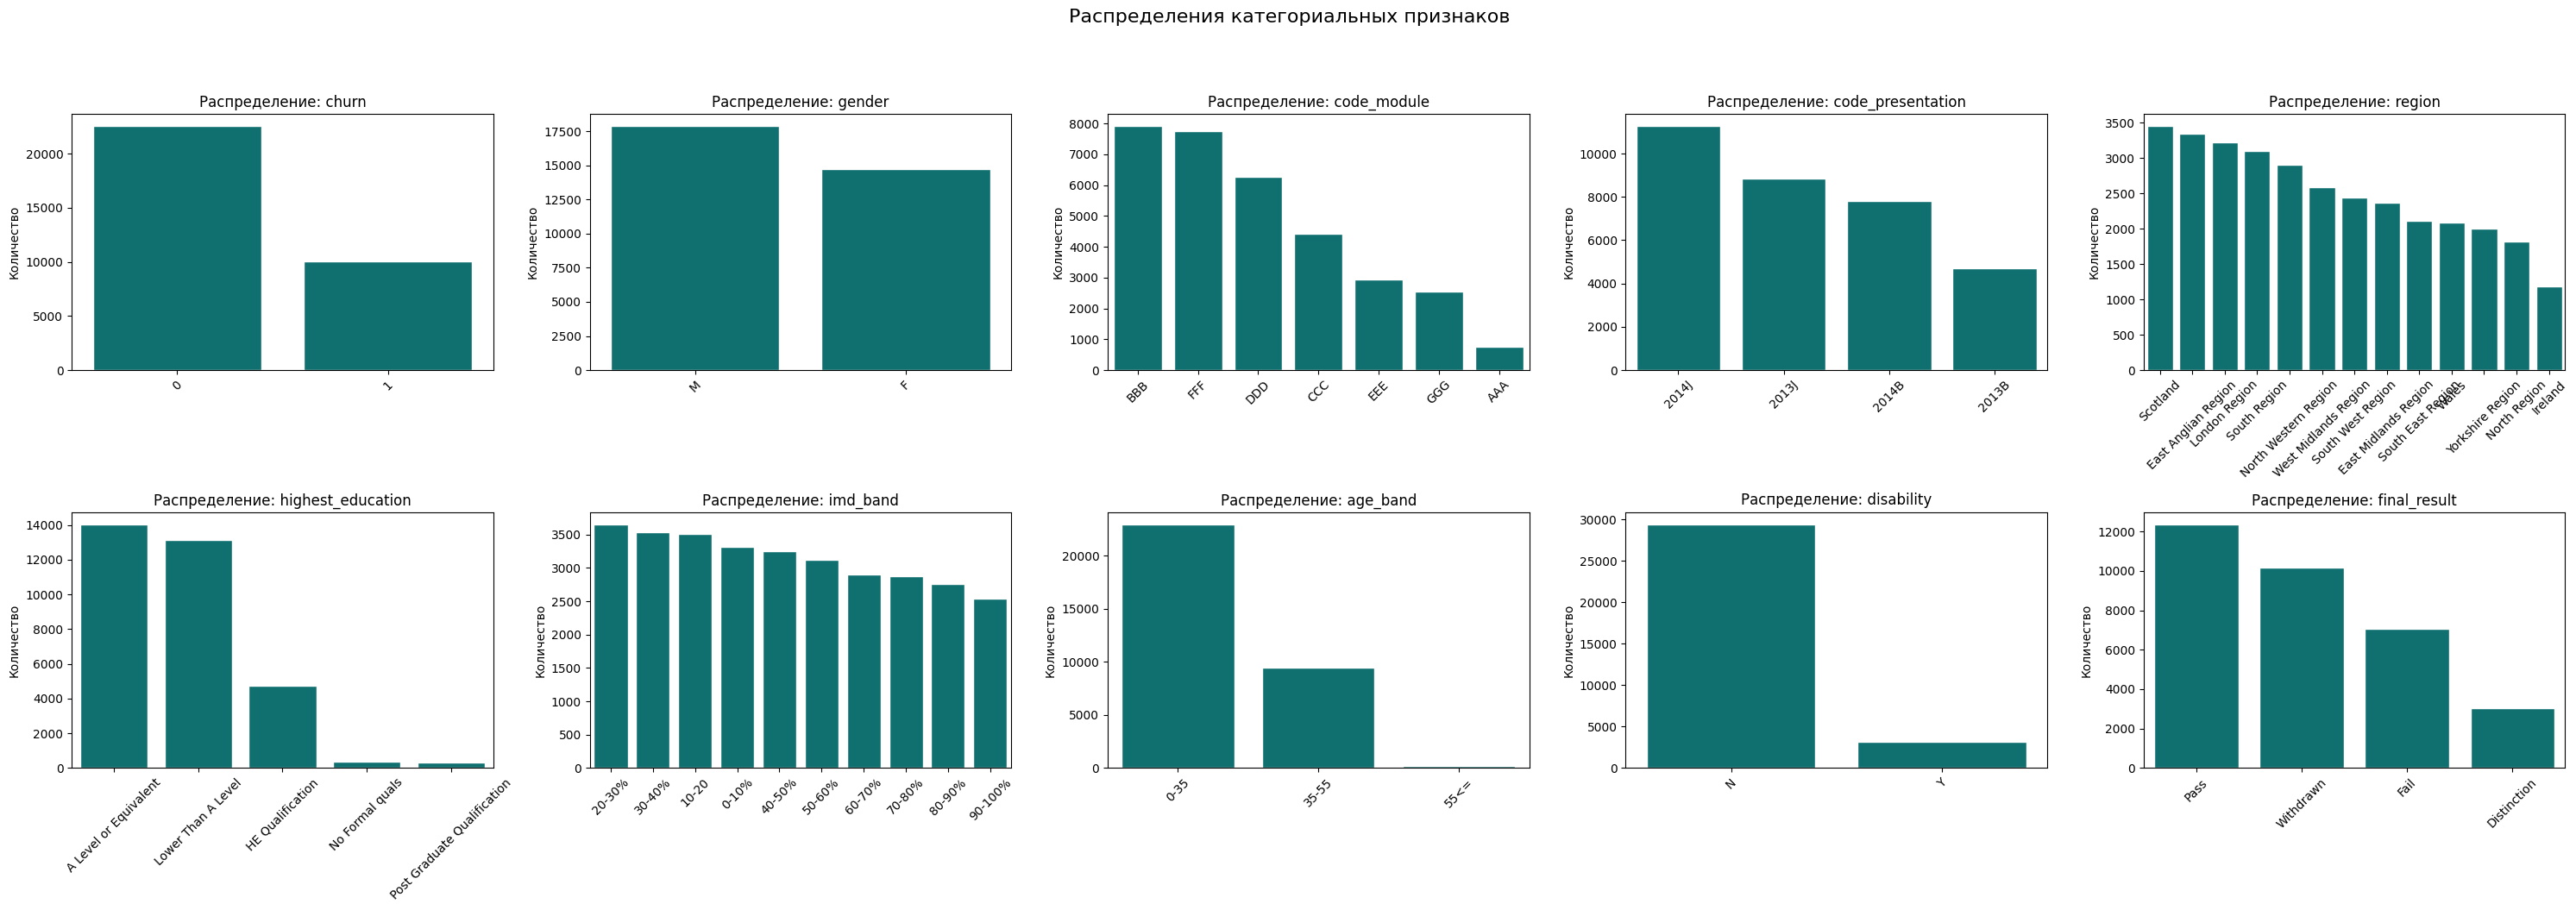

In [ ]:
columns = [
    'churn', 'gender', 'code_module', 'code_presentation',
    'region', 'highest_education', 'imd_band', 'age_band',
    'disability', 'final_result'
]

# Настройки графиков
fig, axes = plt.subplots(2, 5, figsize=(30, 10))
fig.suptitle('Распределения категориальных признаков', fontsize=16, y=1.05)
sns.set_style("whitegrid")

# Цикл по колонкам и осям
for ax, col in zip(axes.flatten(), columns):
    counts = df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=ax, color="teal")
    ax.set_title(f'Распределение: {col}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Количество')
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

***

### Анализ распределения категориальных признаков: выводы

Анализ гистограмм категориальных признаков позволил выявить ключевые характеристики аудитории студентов и особенности курсов.

1.  **Целевая переменная `churn` и связанный с ней `final_result`:**
    *   **Дисбаланс классов:** Как и было отмечено, наблюдается явный дисбаланс в целевой переменной `churn`: студентов, продолживших обучение (0), примерно в два раза больше, чем ушедших в отток (1). Это необходимо будет учесть при построении модели (через взвешивание классов или специальные метрики).
    *   **Утечка данных:** Признак `final_result` (Pass, Fail, Withdrawn, Distinction) является прямым следствием прохождения курса и становится известен только по его окончании. Категория `Withdrawn` (отозвал заявление) напрямую соответствует оттоку. **Использование этого признака для предсказания оттока является утечкой данных и недопустимо.** Его следует удалить перед обучением.

2.  **Демографические и социальные признаки:**
    *   **`gender`:** Количество студентов мужского (M) и женского (F) пола сопоставимо, с небольшим преобладанием мужчин. Явного перекоса нет.
    *   **`age_band`:** Подавляющее большинство студентов (более 2/3) относятся к возрастной группе "0-35". Это доминирующая аудитория. Группы "35-55" и "55<=" значительно меньше.
    *   **`disability`:** Абсолютное большинство студентов не имеют задокументированной инвалидности. Этот признак сильно несбалансирован, что может затруднить выявление его влияния на отток.
    *   **`highest_education`:** Основная масса студентов имеет образование уровня "A Level or Equivalent" и "Lower Than A Level". Студентов с высшим образованием ("HE Qualification") или без формальной квалификации значительно меньше.
    *   **`region` и `imd_band` (индекс бедности):** Распределение по регионам и по уровню благосостояния (`imd_band`) достаточно равномерное, без ярко выраженных доминирующих категорий. Это хорошие признаки для модели, так как они содержат вариативность.

3.  **Признаки, связанные с курсами:**
    *   **`code_module` и `code_presentation`:** Распределение по модулям и семестрам неравномерное. Модули `BBB` и `FFF` являются самыми популярными, а `AAA` и `GGG` — самыми малочисленными. Это может влиять на отток: на разных курсах могут быть разные показатели отсева. Эти признаки важны для анализа и, возможно, для построения отдельных моделей для разных курсов.

### Итоговые рекомендации:

*   **Удалить `final_result`:** Обязательно исключить из-за утечки данных.
*   **Учесть дисбаланс:** Принять меры по работе с дисбалансом классов в `churn` и `disability`.
*   **Обработать категории:** Все категориальные признаки необходимо будет преобразовать в числовой формат для модели (например, с помощью One-Hot Encoding или Target Encoding).
*   **Сфокусироваться на группах:** Признаки `age_band` и `highest_education` имеют доминирующие группы, что может быть использовано для создания более простых бинарных признаков (например, "молодой студент" vs "старше", "с высшим образованием" vs "без").

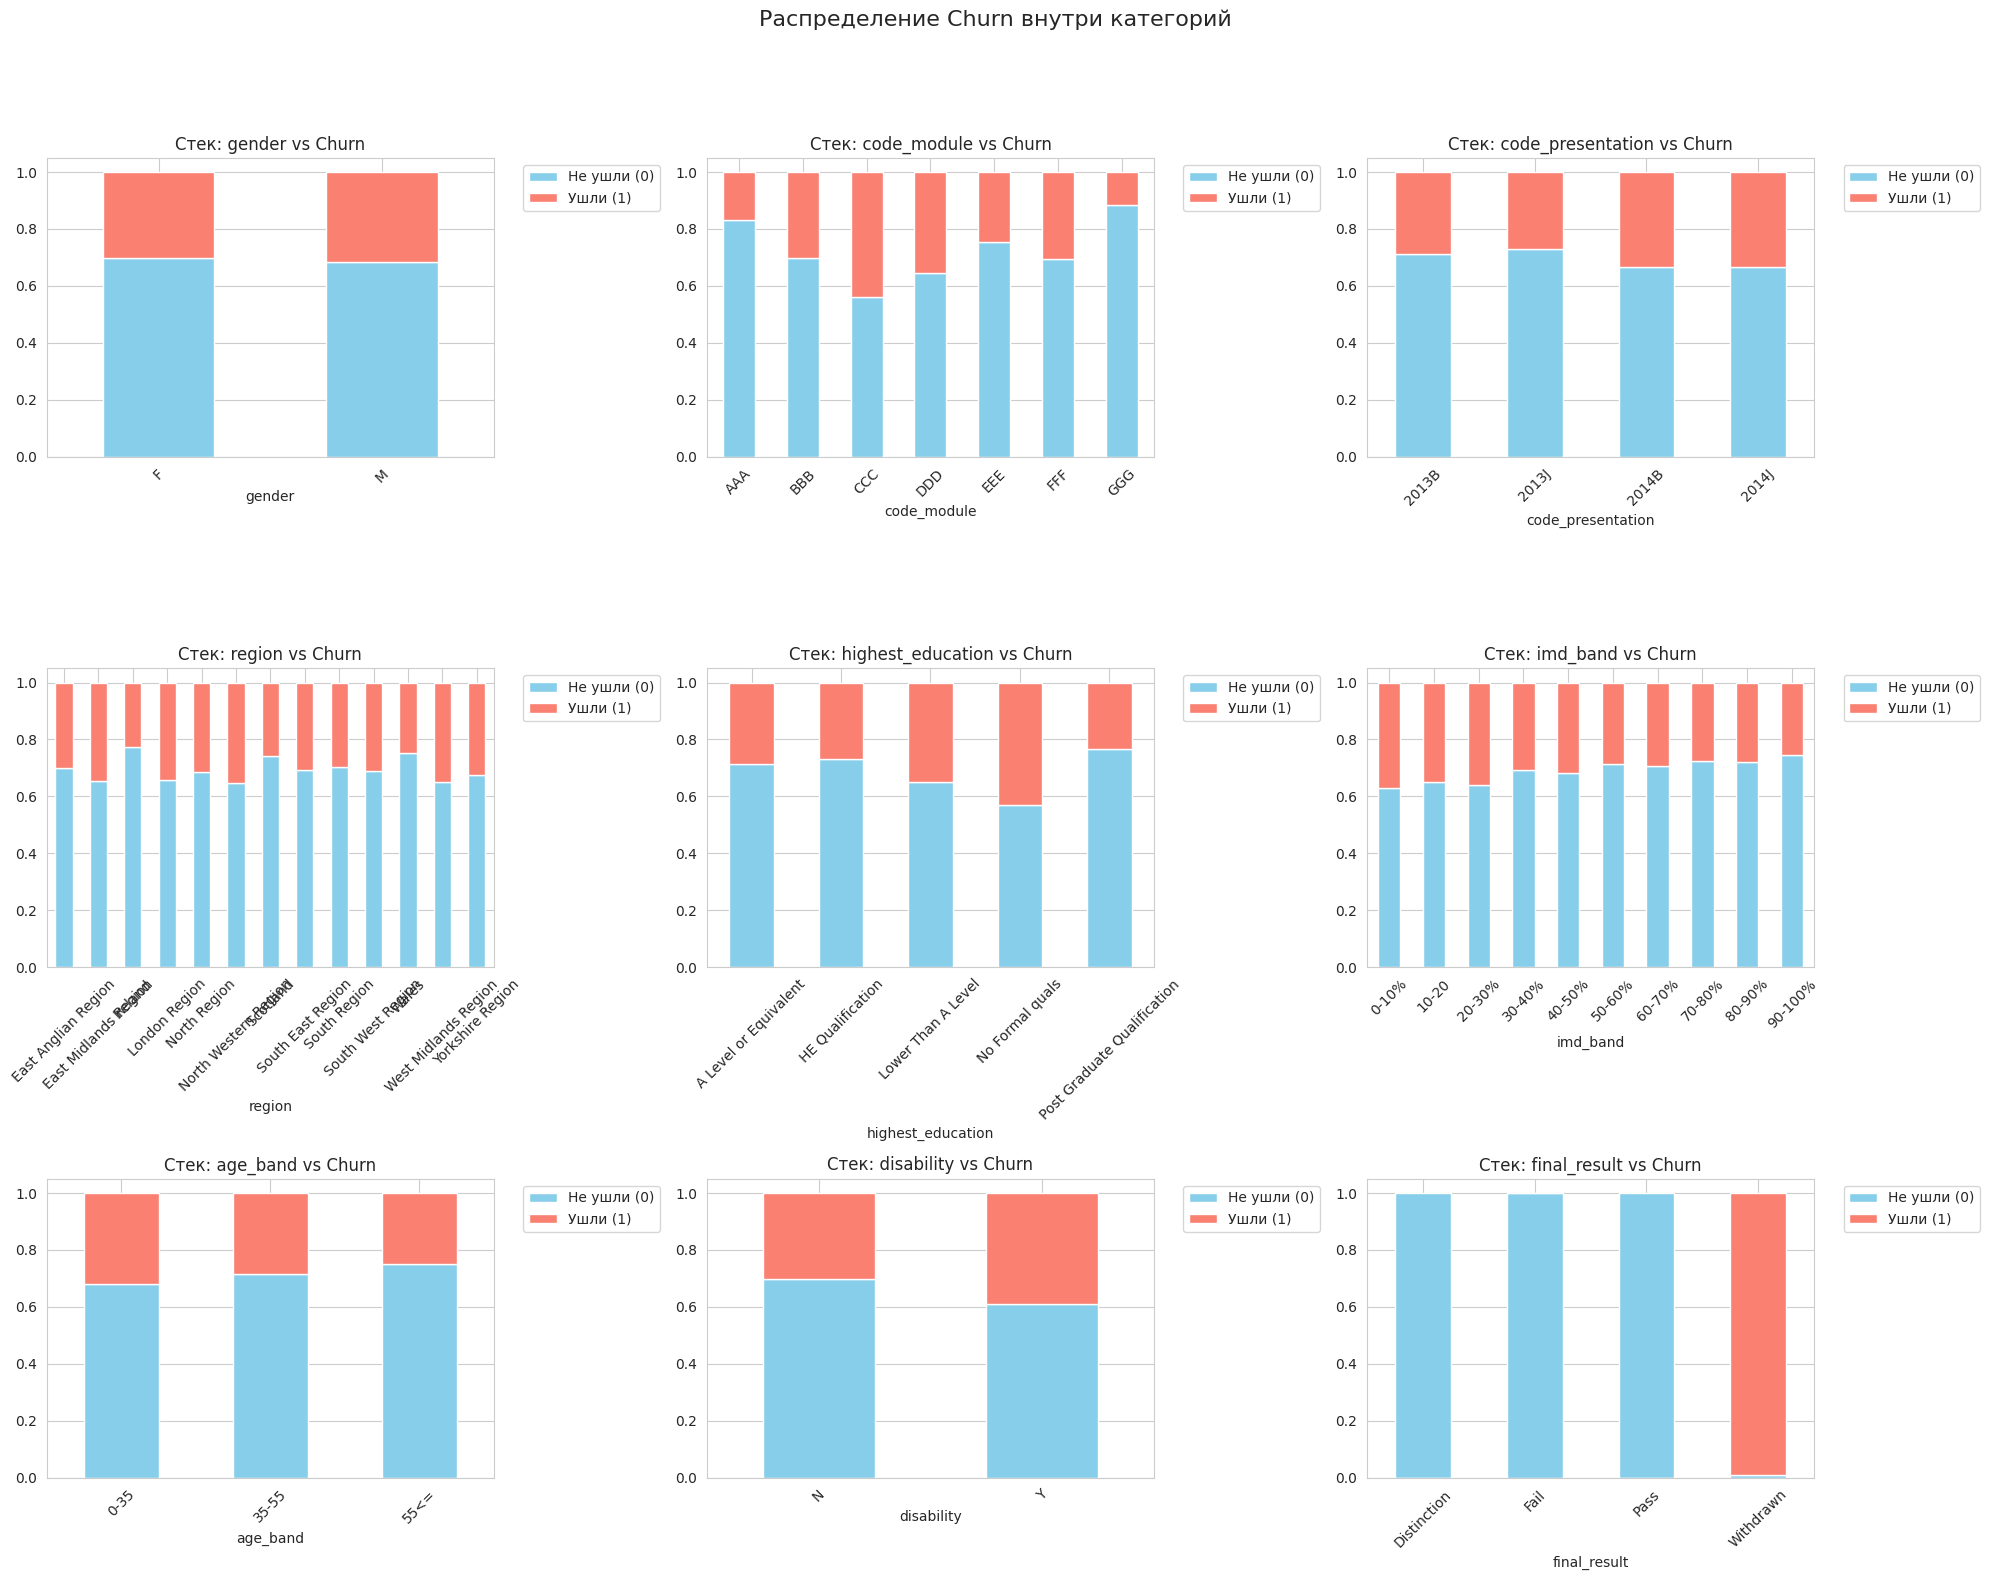

In [ ]:
columns = [
    'gender', 'code_module', 'code_presentation',
    'region', 'highest_education', 'imd_band', 'age_band',
    'disability', 'final_result'
]

fig2, axes2 = plt.subplots(3, 3, figsize=(20, 15))
fig2.suptitle('Распределение Churn внутри категорий', fontsize=16, y=1.05)

axes2 = axes2.flatten()

for i, col in enumerate(columns):
    crosstab = pd.crosstab(df[col], df['churn'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, ax=axes2[i], color=['skyblue', 'salmon'])
    axes2[i].set_title(f'Стек: {col} vs Churn', fontsize=12)
    axes2[i].legend(['Не ушли (0)', 'Ушли (1)'], bbox_to_anchor=(1.05, 1), loc='upper left')
    axes2[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


***

### Дополнение: Анализ доли оттока (Churn Rate) внутри категорий

Анализ стековых диаграмм позволил визуально оценить *долю оттока* (churn rate) внутри каждой категории и выявить наиболее влиятельные признаки, что дополняет выводы о распределениях.

1.  **Подтверждение утечки данных:**
    *   График **`final_result vs Churn`** наглядно подтверждает вывод об утечке данных: категория `Withdrawn` на 100% состоит из ушедших студентов (churn=1), а все остальные (`Pass`, `Fail`, `Distinction`) — из оставшихся (churn=0). Это окончательно доказывает необходимость удаления данного признака.

2.  **Выявление сильных предикторов:**
    *   **`highest_education`:** Наиболее сильное влияние на отток оказывает уровень образования. Студенты без формальной квалификации (`No Formal quals`) и, что интересно, с высшим образованием (`HE Qualification`) уходят заметно чаще.
    *   **`code_module`:** Существует сильная зависимость оттока от конкретного учебного модуля. Например, на курсе `CCC` доля ушедших студентов максимальна, а на курсе `GGG` — минимальна.
    *   **`disability`:** Студенты с инвалидностью (`disability` = Y) демонстрируют более высокий процент оттока по сравнению со студентами без нее.

3.  **Выявление слабых предикторов:**
    *   **`imd_band`:** Наблюдается слабая тенденция: в более бедных районах (например, `imd_band` 0-10%) уровень оттока немного выше, чем в более благополучных.
    *   **`gender`, `region`, `age_band`:** Эти признаки показывают очень схожий уровень оттока во всех своих категориях, что говорит об их низкой предсказательной силе в отдельности. Их влияние на модель, вероятно, будет минимальным.

`final_result` очень сильно коррелирует с оттоком. Фактически, этот признак буквально следует из `date_unregistration`, а так как мы генерировали `churn` относительно этого признака, то `final_result` является утечкой данных.






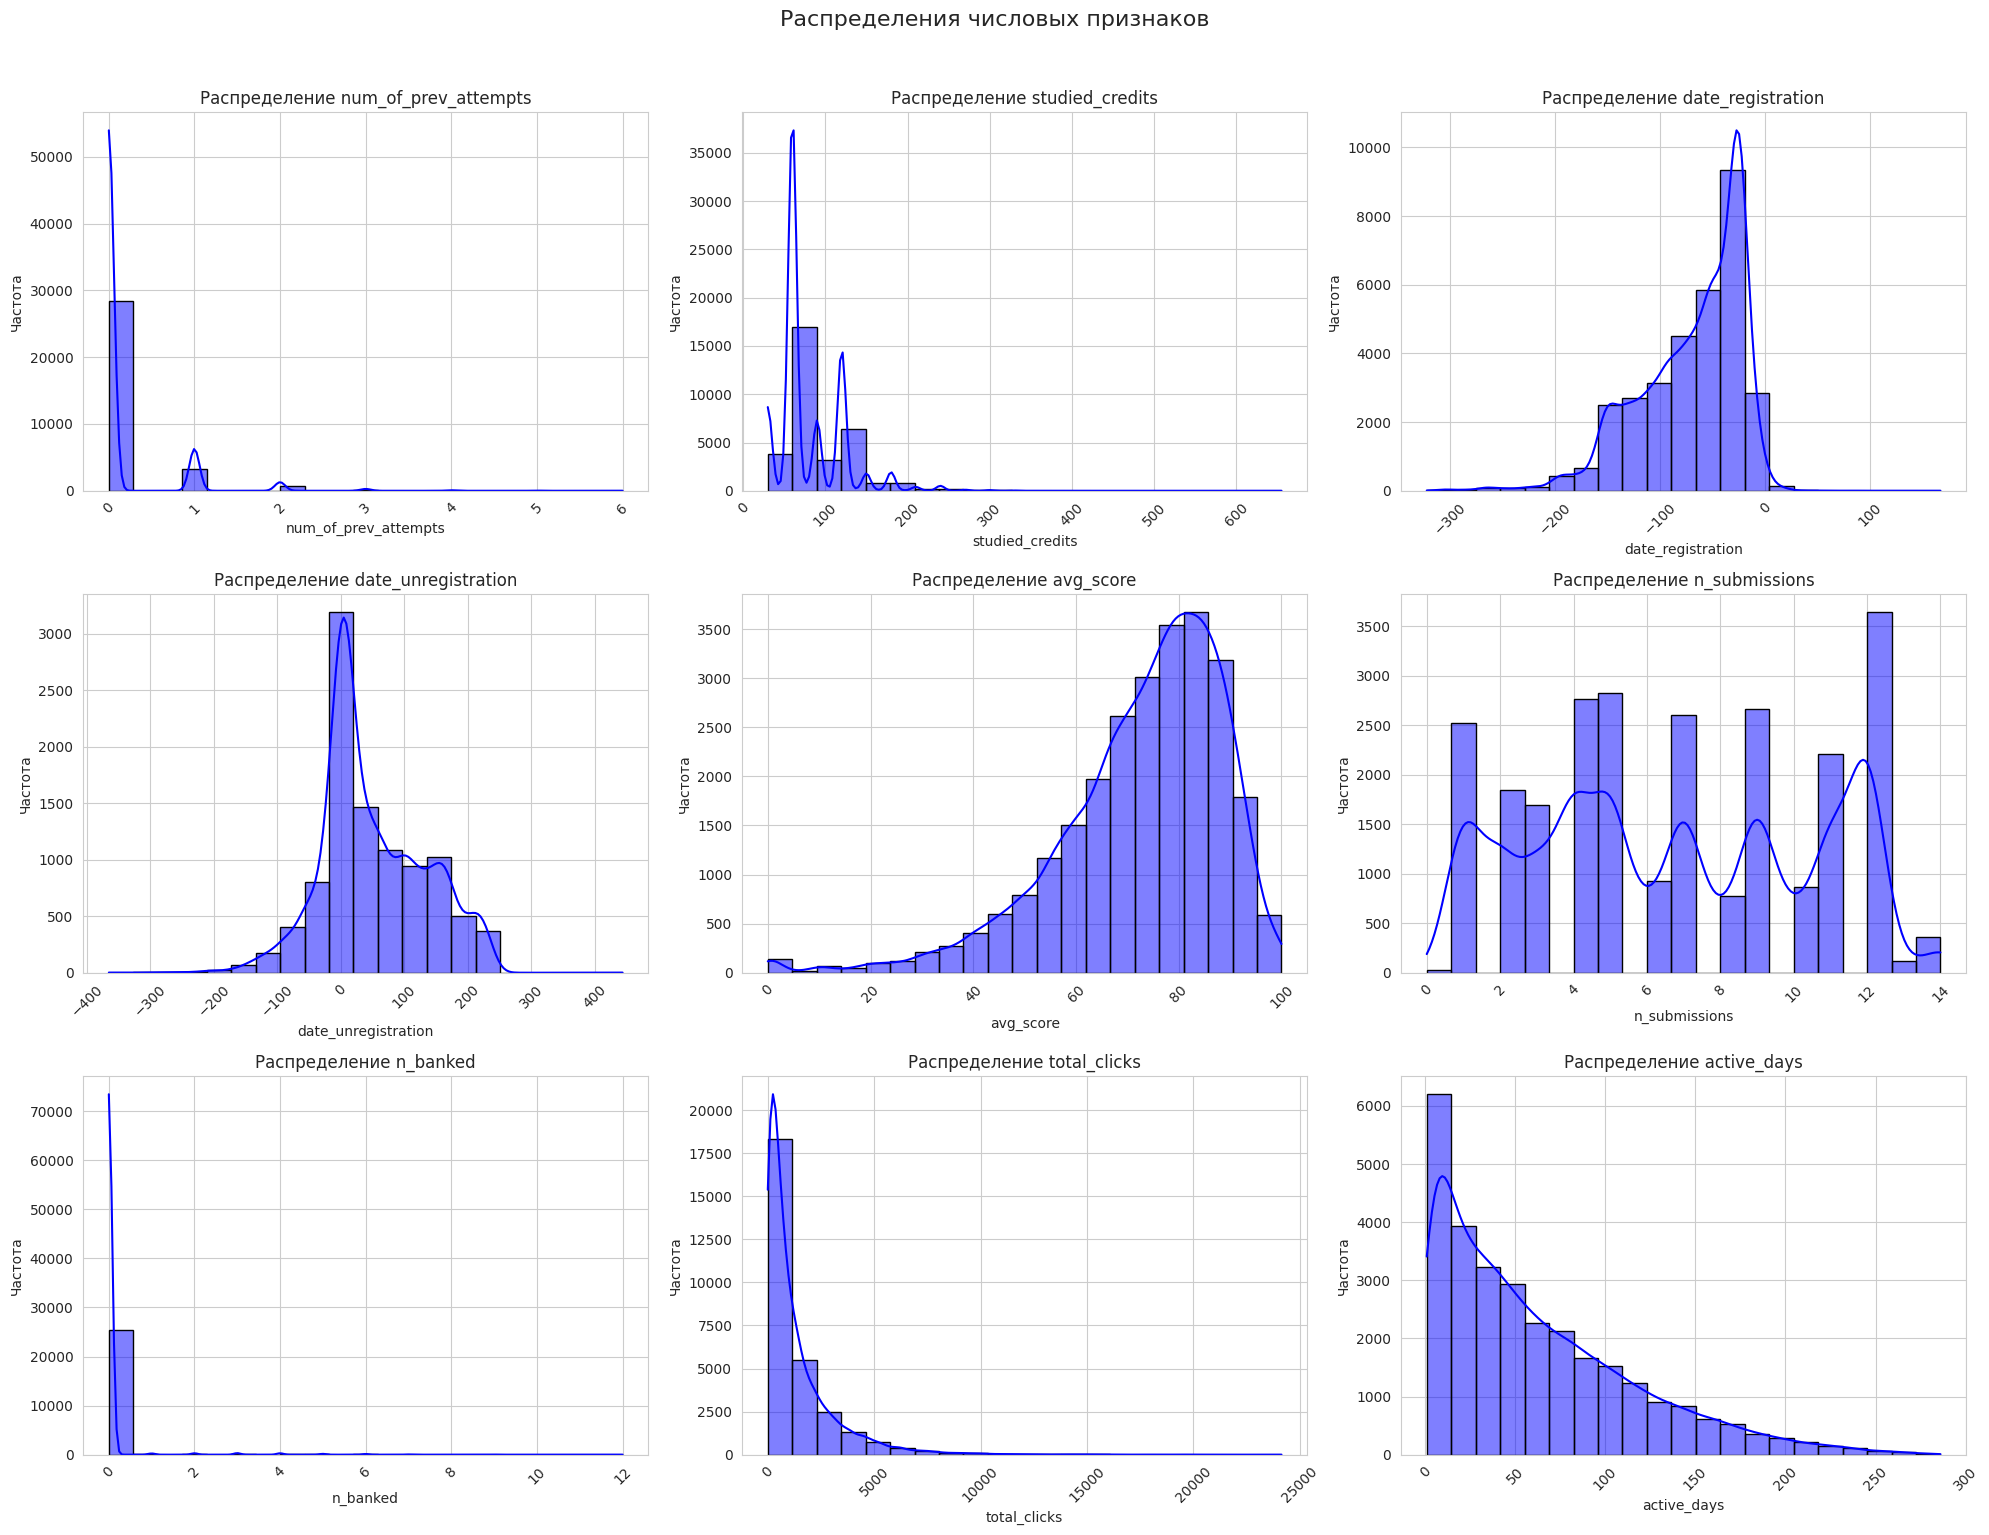

In [ ]:
columns = [
    'num_of_prev_attempts', 'studied_credits', 'date_registration',
    'date_unregistration', 'avg_score', 'n_submissions',
    'n_banked', 'total_clicks', 'active_days'
]


fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Распределения числовых признаков', fontsize=16, y=1.02)
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.histplot(data = df, x = col,ax = axes[i], bins = 21, kde=True, color='blue', edgecolor='black',)
    axes[i].set_title(f'Распределение {col}', fontsize=12)
    axes[i].set_ylabel('Частота')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

*   **Признаки с сильным правым скосом (`num_of_prev_attempts`, `n_banked`, `total_clicks`, `active_days`):**
    *   **Наблюдение:** Подавляющее большинство наблюдений сконцентрировано у нулевых или околонулевых значений, с длинным "хвостом" в сторону больших значений. Например, большинство студентов не имели предыдущих попыток сдачи (`num_of_prev_attempts`) и имеют низкую активность (`active_days`).
    *   **Интерпретация:** Такое распределение характерно для показателей, где "отсутствие" или "малое количество" является нормой. Это говорит о том, что есть небольшая, но потенциально важная группа "суперактивных" или "опытных" студентов.
    *  Для моделей, чувствительных к масштабу и распределению (например, линейных), может потребоваться **логарифмическая трансформация** (например, `log(1+x)`) для `total_clicks` и `active_days`, чтобы "сжать" хвост и сделать распределение более симметричным. Признаки `num_of_prev_attempts` и `n_banked` можно рассматривать как **бинарные флаги** (0 - нет, 1 - есть), так как почти все значения равны нулю.

*   **Признаки с нормальным или близким к нормальному распределением (`date_registration`, `avg_score`):**
    *   **Наблюдение:** `avg_score` имеет практически идеальное колоколообразное распределение со смещением влево (большинство студентов имеют высокие баллы). `date_registration` также напоминает нормальное распределение, показывая, что большинство регистраций происходит в определенный период до начала курса.
    *   **Интерпретация:** Эти признаки хорошо сбалансированы и, вероятно, не потребуют сложных трансформаций. Небольшой левый скос у `avg_score` указывает на наличие "хвоста" неуспевающих студентов, что является важным сигналом для модели оттока.

*   **Признаки с мультимодальным (многовершинным) распределением (`studied_credits`, `n_submissions`):**
    *   **Наблюдение:** На гистограммах этих признаков видно несколько явных пиков. Например, у `studied_credits` пики приходятся на стандартные объемы учебных программ (например, 60, 120 кредитов). У `n_submissions` пики, вероятно, соответствуют количеству обязательных заданий в разных курсах.
    *   **Интерпретация:** Эти признаки по своей природе не являются непрерывными, а скорее **дискретными или категориальными**. Студенты выбирают из ограниченного набора опций. Модель может извлечь пользу, если будет рассматривать эти значения как отдельные категории, а не как непрерывную шкалу.

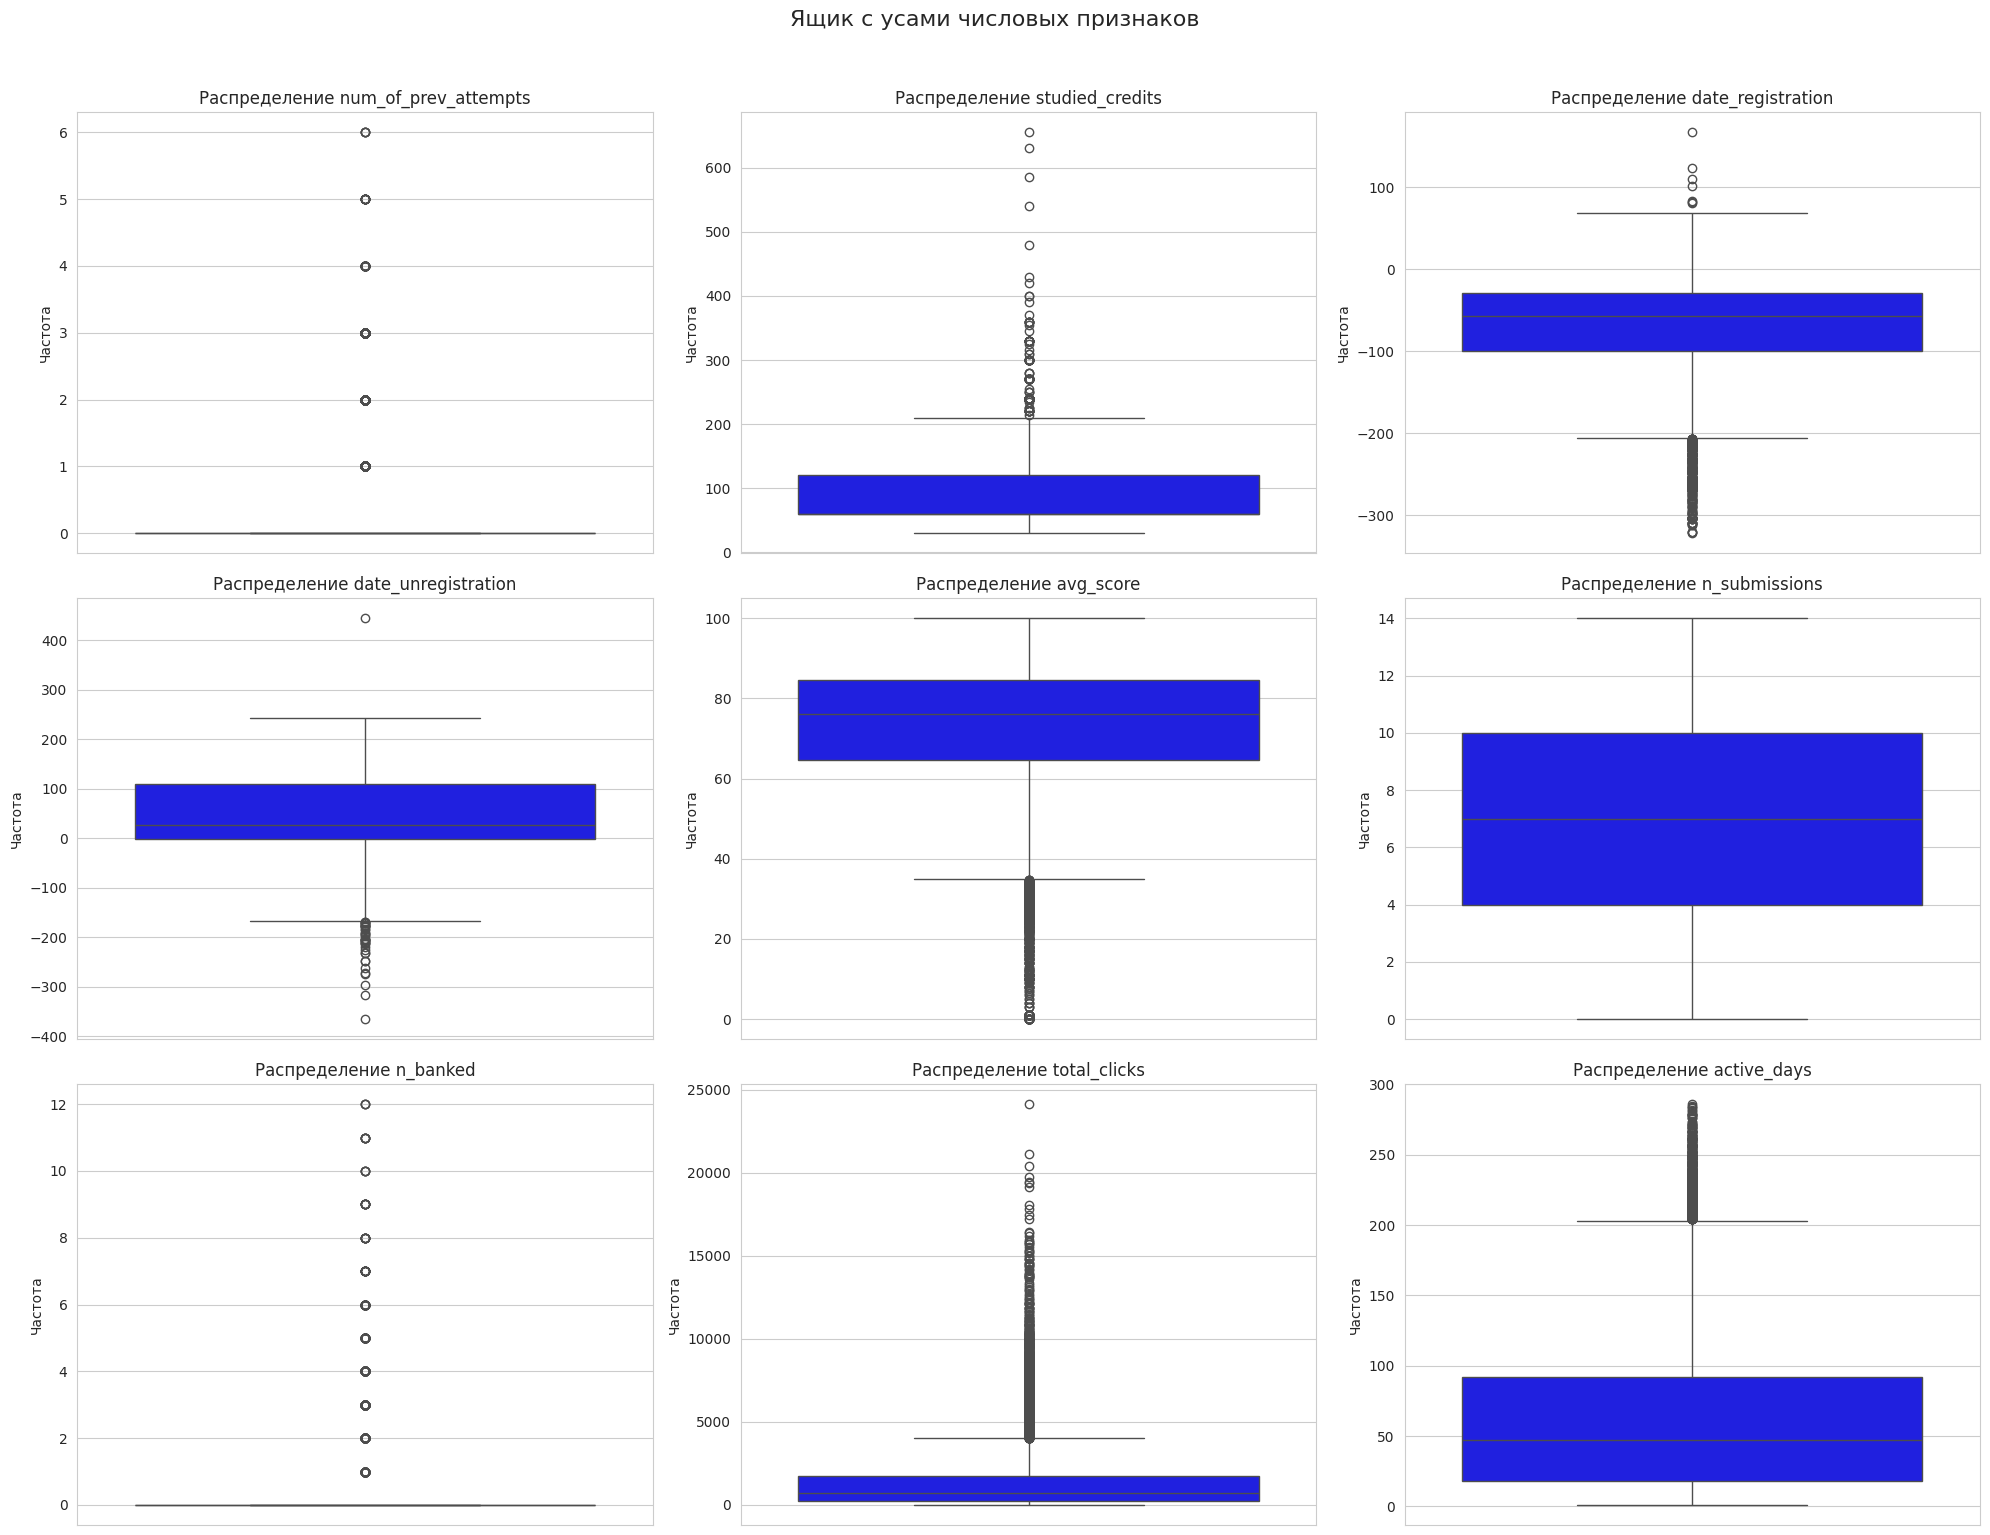

In [ ]:
fig1, axes1 = plt.subplots(3, 3, figsize=(20, 15))
fig1.suptitle('Ящик с усами числовых признаков', fontsize=16, y=1.02)
axes1 = axes1.flatten()

for i, col in enumerate(columns):
    sns.boxplot(data = df[col], ax = axes1[i], color='blue')
    axes1[i].set_title(f'Распределение {col}', fontsize=12)
    axes1[i].set_ylabel('Частота')
    axes1[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

*   **Выраженные выбросы (`num_of_prev_attempts`, `n_banked`, `total_clicks`, `active_days`):**
    *   **Наблюдение:** Для всех этих признаков "ящик" (IQR) очень узкий и прижат к нулю, а почти все значения, отличные от нуля или близких к нему, помечены как выбросы.
    *   **Интерпретация:** Это подтверждает выводы из гистограмм. "Выбросы" здесь — это не ошибки, а реальные, хотя и редкие, случаи (например, студент с 6-ю предыдущими попытками). Они представляют собой отдельную когорту студентов, поведение которых отличается от большинства.
    *   Не стоит удалять эти выбросы. Они несут ценную информацию, стоит логарифмировать или создать бинарные признаки.

*   **Симметричные распределения (`date_registration`, `date_unregistration`):**
    *   **Наблюдение:** Медиана (линия внутри ящика) находится примерно посередине, а "усы" имеют схожую длину. Это говорит об относительной симметрии основной массы данных.
    *   **Интерпретация:** Основная часть студентов регистрируется и отменяет регистрацию в предсказуемые временные окна.

*   **Широкий разброс (`avg_score`, `n_submissions`):**
    *   **Наблюдение:** "Ящики" для этих признаков достаточно широкие, что указывает на высокую вариативность в данных. У студентов сильно различаются средние баллы и количество выполненных заданий.
    *   **Интерпретация:** Эта вариативность — именно то, что нужно модели для поиска закономерностей. Высокий разброс означает, что признак обладает хорошей разделительной способностью.


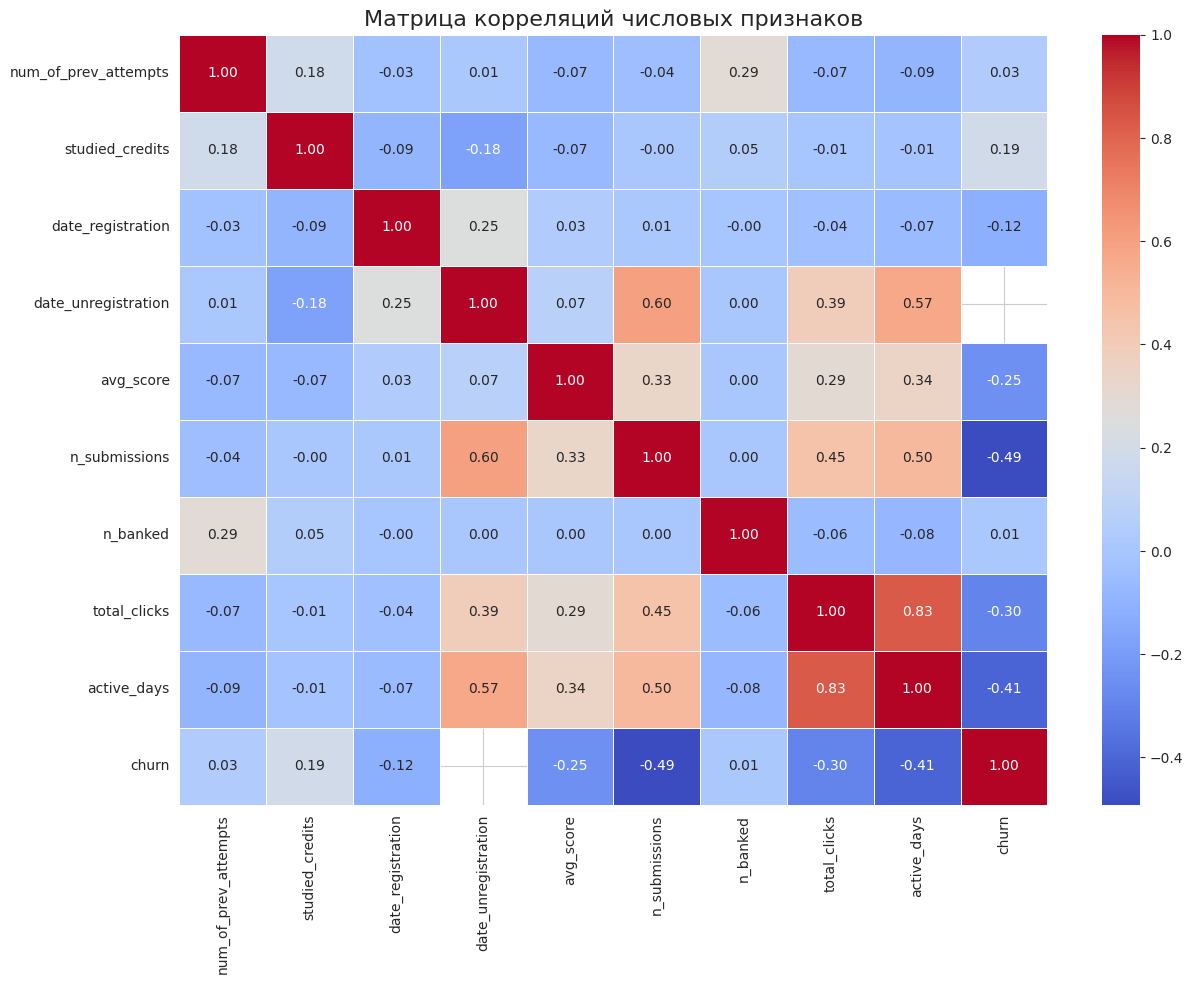

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id_student')
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(14, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5
)

plt.title('Матрица корреляций числовых признаков', fontsize=16)
plt.show()

### Наблюдения по матрице корреляций:
#### 1. Обнаружена сильная мультиколлинеарность

Выявлена очень сильная положительная корреляция между признаками **`total_clicks`** (общее количество кликов) и **`active_days`** (количество активных дней) со значением **0.83**.

*   **Интерпретация:** Эти два признака несут в себе практически идентичную информацию. Логично, что чем больше дней студент активен на платформе, тем больше кликов он совершает.
*   **Риск:** Использование обоих признаков в моделях, чувствительных к мультиколлинеарности (например, в логистической регрессии), может привести к нестабильности коэффициентов и неверной интерпретации важности признаков.
*   Необходимо исключить один из этих признаков. Сравнивая их корреляцию с целевой переменной `churn`, мы видим, что `active_days` (-0.41) является более сильным предиктором, чем `total_clicks` (-0.30). **Исключим признак `total_clicks` из набора данных для моделирования.**


#### 2. Определены ключевые предикторы оттока

Анализ последнего столбца матрицы (`churn`) выявил наиболее влиятельные признаки:

1.  **`n_submissions` (Корреляция: -0.49):** **Самый сильный предиктор.** Отрицательная связь означает, что чем больше заданий студент отправил на проверку, тем значительно **ниже** вероятность его ухода. Это главный показатель вовлеченности.
2.  **`active_days` (Корреляция: -0.41):** Второй по силе предиктор. Чем больше дней студент был активен, тем **ниже** вероятность оттока.
3.  **`avg_score` (Корреляция: -0.25):** Умеренная отрицательная связь. Студенты с более высокой успеваемостью реже уходят с курса.

Эти три признака формируют ядро нашей будущей модели.

#### 3. Дополнительные инсайты

*   **`studied_credits` (Корреляция: 0.19):** Наблюдается слабая, но интересная **положительная** корреляция с оттоком. Это может свидетельствовать о том, что студенты, берущие на себя повышенную учебную нагрузку (больше кредитов), чаще не справляются и уходят. Этот признак стоит сохранить и, возможно, использовать для создания новых гипотез или сегментации пользователей.


***
### Итоговые выводы для предобработки:
#### Ключевые предикторы оттока

Наиболее сильное влияние на целевую переменную `churn` оказывают следующие признаки:

*   **Числовые признаки (по силе влияния):**
    1.  **`n_submissions` (количество сданных работ):** Самый сильный предиктор. Чем больше работ сдает студент, тем ниже вероятность оттока.
    2.  **`active_days` (количество активных дней):** Высокая активность на платформе сильно коррелирует с удержанием студента.
    3.  **`avg_score` (средний балл):** Успеваемость является важным фактором; студенты с низкими баллами уходят чаще.

*   **Категориальные признаки:**
    1.  **`highest_education` (уровень образования):** Демонстрирует явную разницу в уровне оттока между разными группами.
    2.  **`code_module` (код модуля):** Отток сильно варьируется в зависимости от конкретного курса.
    3.  **`disability` (наличие инвалидности):** Студенты с инвалидностью показывают более высокий уровень оттока.

#### Выявленные проблемы в данных

1.  **Утечка данных (Data Leakage):** Признаки `final_result` и `date_unregistration` содержат информацию, которая становится доступна только *после* факта оттока. Их использование для прогнозирования недопустимо.
2.  **Мультиколлинеарность:** Признаки `total_clicks` и `active_days` сильно скоррелированы (0.83), неся дублирующую информацию.
3.  **Пропущенные значения:** Значительное количество пропусков в ключевых признаках (`avg_score`, `n_submissions`, `active_days`) возникло из-за объединения таблиц (`left join`). Это означает не случайное отсутствие данных, а фактическое отсутствие активности у студента.
4.  **Скошенные распределения:** Некоторые важные числовые признаки (например, `active_days`) имеют сильно скошенное вправо распределение, что может негативно сказаться на линейных моделях.



***
## 3. Предобработка данных

На основе выводов, полученных в ходе исследовательского анализа, проведем комплексный этап предобработки данных.

3.1. Удаление избыточных признаков и устранение утечек

In [ ]:
columns_clear = ['final_result', 'date_unregistration', 'total_clicks', 'id_student']
df_cleans = df.drop(columns = columns_clear)
df_cleans.head(5)

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,avg_score,n_submissions,n_banked,active_days,churn
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,-159.0,82.0,5.0,0.0,40.0,0
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,-53.0,66.4,5.0,0.0,80.0,0
2,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,-92.0,NaN,NaN,NaN,12.0,1
3,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,-52.0,76.0,5.0,0.0,123.0,0
4,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,-176.0,54.4,5.0,0.0,70.0,0


#### 3.2. Обработка пропущенных значений

In [ ]:
fill_values = {
    'avg_score': 0,
    'n_submissions': 0,
    'active_days': 0,
    'n_banked':0,
    'date_registration':0,
    'imd_band': df_cleans['imd_band'].mode()[0]
}

# Применяем все правила за один раз
df_cleans = df_cleans.fillna(fill_values)
df_cleans.head(5)
df_cleans.isnull().sum()

,0
code_module,0
code_presentation,0
gender,0
region,0
highest_education,0
imd_band,0
age_band,0
num_of_prev_attempts,0
studied_credits,0
disability,0


-   **Числовые признаки (`avg_score`, `n_submissions`, `active_days` и др.):** Пропуски в этих столбцах были заполнены нулями. Такая стратегия была выбрана, поскольку пропуск в агрегированных данных об активности или успеваемости означает фактическое отсутствие этой активности (студент не сдавал тесты, не заходил на платформу).
-   **Категориальные признаки (`imd_band`):** Незначительное количество пропусков было заполнено модальным (наиболее частым) значением, что является стандартной практикой и вносит минимальные искажения в распределение.

#### 3.3. Кодирование и трансформация признаков


In [ ]:
categorical_cols = ['code_presentation','gender', 'region', 'code_module', 'highest_education', 'imd_band', 'age_band', 'disability']

# Применяем get_dummies
df_encoded = pd.get_dummies(df_cleans, columns=categorical_cols, drop_first=True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 46 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   num_of_prev_attempts                           32593 non-null  int64  
 1   studied_credits                                32593 non-null  int64  
 2   date_registration                              32593 non-null  float64
 3   avg_score                                      32593 non-null  float64
 4   n_submissions                                  32593 non-null  float64
 5   n_banked                                       32593 non-null  float64
 6   active_days                                    32593 non-null  float64
 7   churn                                          32593 non-null  int64  
 8   code_presentation_2013J                        32593 non-null  bool   
 9   code_presentation_2014B                        325

-   **Кодирование категориальных признаков:** Все оставшиеся категориальные переменные (`gender`, `region`, `code_module` и др.) были преобразованы в числовой формат с помощью техники **One-Hot Encoding** (`pd.get_dummies`). Для избежания мультиколлинеарности фиктивных переменных был использован параметр `drop_first=True`.

In [ ]:
log_cols = ['active_days']
scale_cols = ['num_of_prev_attempts', 'studied_credits', 'avg_score', 'n_submissions', 'n_banked']

# Создаем трансформер
preprocessor = make_column_transformer(
    (FunctionTransformer(np.log1p), log_cols),  # Логарифмируем
    (StandardScaler(), scale_cols),             # Масштабируем
    remainder='passthrough'                     # Остальные колонки оставляем как есть
)

df_transformed = preprocessor.fit_transform(df_encoded)

new_col_names = log_cols + scale_cols + list(preprocessor.named_transformers_['remainder'].get_feature_names_out())
df_final = pd.DataFrame(df_transformed, columns=new_col_names, index=df.index)

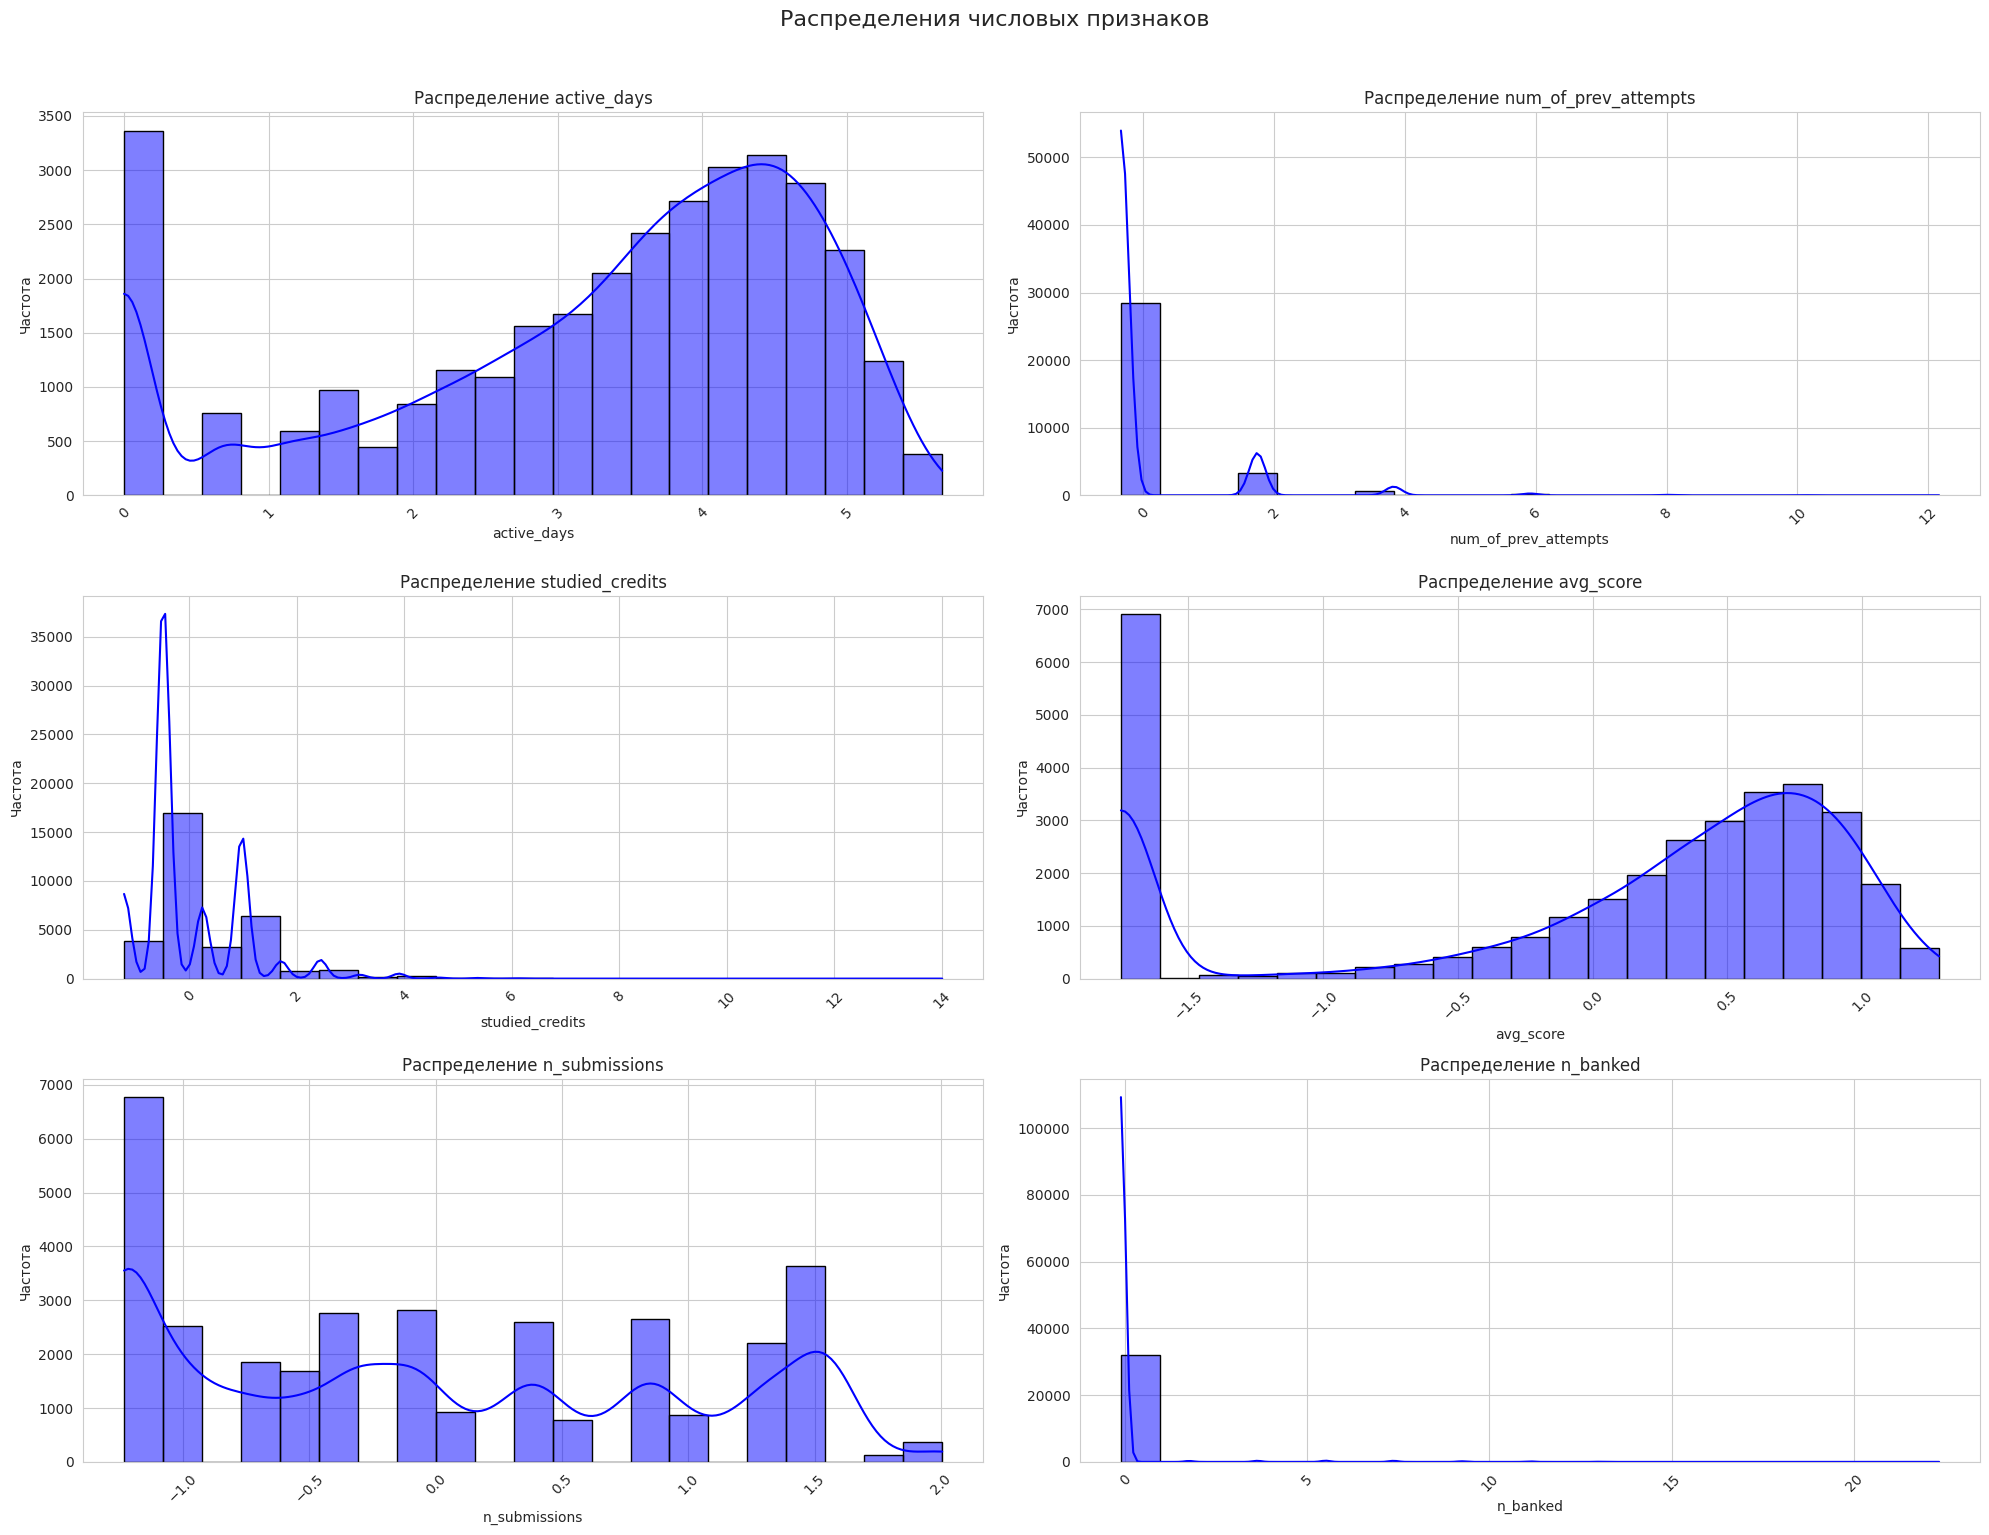

In [ ]:
columns = [
    'active_days', 'num_of_prev_attempts', 'studied_credits',
    'avg_score', 'n_submissions', 'n_banked'
]


fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Трансформированные признаки', fontsize=16, y=1.02)
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.histplot(data = df_final, x = col,ax = axes[i], bins = 21, kde=True, color='blue', edgecolor='black',)
    axes[i].set_title(f'Распределение {col}', fontsize=12)
    axes[i].set_ylabel('Частота')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

-   **Трансформация и масштабирование числовых признаков:** Для числовых признаков был применен `ColumnTransformer`, который позволил выполнить две операции одновременно:
    1.  **Логарифмическая трансформация:** К признаку `active_days`, имевшему сильно скошенное распределение, была применена функция `log(1+x)`. Как видно на итоговом графике, это позволило сделать его распределение более симметричным и близким к нормальному.
    2.  **Стандартизация:** Все числовые признаки были отмасштабированы с помощью `StandardScaler`. Это привело их к единому масштабу со средним значением, близким к 0, и стандартным отклонением, равным 1, что является необходимым условием для корректной работы многих алгоритмов.

***
### 4. Построение и оценка моделей

#### 4.1. Подготовка к моделированию

In [ ]:
X = df_final.drop(columns=['churn'])
y = df_final['churn']

y = y.astype(int)
# test_size=0.2 означает, что 20% данных пойдут в тест
# stratify=y гарантирует, что в обучающей и тестовой выборках
# будет одинаковое соотношение классов (очень важно при дисбалансе!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Проверяем размеры
print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")

Размер X_train: (26074, 45)
Размер X_test: (6519, 45)


In [ ]:
print(f"Тип данных в y_train: {y_train.dtype}")
print("Первые 5 значений y_train:")
print(y_train.head())

Тип данных в y_train: int64
Первые 5 значений y_train:
17697    1
22584    0
19839    0
11395    0
28831    0
Name: churn, dtype: int64


Перед обучением моделей итоговый набор данных был разделен на обучающую (80%) и тестовую (20%) выборки с помощью функции `train_test_split`. Для корректной оценки на несбалансированных данных был применен параметр `stratify=y`, который гарантирует сохранение исходного соотношения классов (отток/остались) в обеих выборках.

#### 4.2. Обучение и сравнение моделей

##### 4.2.1. Логистическая регрессия

In [ ]:
# 1. Инициализируем модель с параметром для балансировки
model_lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# 2. Обучаем модель ТОЛЬКО на обучающих данных
print("Обучение модели LogisticRegression...")
model_lr.fit(X_train, y_train)
print("Обучение завершено.")

# 3. Делаем предсказания на тестовых данных
y_pred = model_lr.predict(X_test)
y_pred_proba = model_lr.predict_proba(X_test)[:, 1] # Вероятности для ROC-AUC

# 4. Оцениваем качество
print("\n" + "="*30)
print("Результаты Логистической регрессии:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("="*30)

# --- Проверка на переобучение ---

# 1. Делаем предсказания на ОБУЧАЮЩИХ данных
y_pred_train = model_lr.predict(X_train)
y_pred_proba_train = model_lr.predict_proba(X_train)[:, 1]

# 2. Оцениваем качество на ОБУЧАЮЩИХ данных
print("\n" + "="*30)
print("Результаты на ОБУЧАЮЩЕЙ выборке (для сравнения):")
print(classification_report(y_train, y_pred_train))
print(f"ROC-AUC на обучающей выборке: {roc_auc_score(y_train, y_pred_proba_train):.4f}")
print("="*30)

Обучение модели LogisticRegression...
Обучение завершено.

Результаты Логистической регрессии:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      4504
           1       0.71      0.88      0.79      2015

    accuracy                           0.85      6519
   macro avg       0.83      0.86      0.84      6519
weighted avg       0.87      0.85      0.86      6519

ROC-AUC: 0.9241

Результаты на ОБУЧАЮЩЕЙ выборке (для сравнения):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     18017
           1       0.70      0.88      0.78      8057

    accuracy                           0.85     26074
   macro avg       0.82      0.85      0.83     26074
weighted avg       0.86      0.85      0.85     26074

ROC-AUC на обучающей выборке: 0.9212


-   **Метод балансировки:** Использовался встроенный параметр `class_weight='balanced'`, который автоматически взвешивает классы обратно пропорционально их частоте.
-   **Результаты:** Модель показала себя очень хорошо. На тестовой выборке `Recall` для класса "1" (отток) составил **0.71**, а `ROC-AUC` — **0.9241**.
-   **Переобучение:** Сравнение метрик на тестовой (0.9241) и обучающей (0.9212) выборках показывает практически идентичные результаты. **Это говорит об отсутствии переобучения и высокой обобщающей способности модели.**

##### 4.2.2. Случайный лес (Random Forest)

In [ ]:
# --- Создание и обучение пайплайна ---

# Создаем пайплайн:
# 1. Сначала SMOTE для балансировки обучающей выборки "на лету"
# 2. Затем RandomForestClassifier для обучения
pipeline_rf = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Обучаем ВЕСЬ пайплайн на обучающих данных
print("Обучение модели RandomForest со SMOTE...")
pipeline_rf.fit(X_train, y_train)
print("Обучение завершено.")

# --- Оценка на ТЕСТОВОЙ выборке ---

# Делаем предсказания на тестовых данных
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

# Оцениваем качество
print("\n" + "="*30)
print("Результаты Случайного леса на ТЕСТОВОЙ выборке:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("="*30)

# ---  Проверка на ПЕРЕОБУЧЕНИЕ ---

# Делаем предсказания на ОБУЧАЮЩИХ данных
y_pred_train_rf = pipeline_rf.predict(X_train)
y_pred_proba_train_rf = pipeline_rf.predict_proba(X_train)[:, 1]

# Оцениваем качество на ОБУЧАЮЩИХ данных
print("\n" + "="*30)
print("Результаты Случайного леса на ОБУЧАЮЩЕЙ выборке (для сравнения):")
print(classification_report(y_train, y_pred_train_rf))
print(f"ROC-AUC на обучающей выборке: {roc_auc_score(y_train, y_pred_proba_train_rf):.4f}")
print("="*30)

Обучение модели RandomForest со SMOTE...
Обучение завершено.

Результаты Случайного леса на ТЕСТОВОЙ выборке:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4504
           1       0.76      0.81      0.79      2015

    accuracy                           0.86      6519
   macro avg       0.84      0.85      0.84      6519
weighted avg       0.87      0.86      0.87      6519

ROC-AUC на тестовой выборке: 0.9361

Результаты Случайного леса на ОБУЧАЮЩЕЙ выборке (для сравнения):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18017
           1       1.00      1.00      1.00      8057

    accuracy                           1.00     26074
   macro avg       1.00      1.00      1.00     26074
weighted avg       1.00      1.00      1.00     26074

ROC-AUC на обучающей выборке: 1.0000


-   **Метод балансировки:** Применялась более сложная техника — алгоритм `SMOTE`, который синтетически генерирует новые примеры миноритарного класса. Модель была встроена в `pipeline` со SMOTE.
-   **Результаты:** На тестовой выборке метрики оказались выше, чем у логистической регрессии: `Recall` = **0.76**, `ROC-AUC` = **0.9261**.
-   **Переобучение:** Модель продемонстрировала **критическое переобучение**. `ROC-AUC` на обучающей выборке достиг идеального значения **1.0**, в то время как на тестовой он был значительно ниже. Это означает, что модель просто "запомнила" обучающие данные и не способна хорошо работать на новых, невидимых данных.

In [ ]:
# Проверяем типы данных в X_train
print("Типы данных до преобразования:")
print(X_train.dtypes.value_counts())

# Преобразуем все колонки в числовой формат, если это возможно
# Это может выдать ошибку, если в какой-то колонке есть нечисловые строки
try:
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    print("\nТипы данных после преобразования:")
    print(X_train.dtypes.value_counts())
except Exception as e:
    print(f"\nОшибка при преобразовании: {e}")

Типы данных до преобразования:
object    45
Name: count, dtype: int64

Типы данных после преобразования:
float64    45
Name: count, dtype: int64


##### 4.2.3. Градиентный бустинг (LightGBM)

In [ ]:
# --- Создание и обучение модели ---
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True, # Встроенный аналог class_weight='balanced'
    random_state=42,
    n_jobs=-1
)

# Обучаем модель на обучающих данных
print("Обучение модели LightGBM...")
lgbm_model.fit(X_train, y_train)
print("Обучение завершено.")


# --- Оценка на ТЕСТОВОЙ выборке ---

# Делаем предсказания на тестовых данных
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Оцениваем качество
print("\n" + "="*30)
print("Результаты LightGBM на ТЕСТОВОЙ выборке:")
print(classification_report(y_test, y_pred_lgbm))
print(f"ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")
print("="*30)

# --- Проверка на ПЕРЕОБУЧЕНИЕ ---

# Делаем предсказания на ОБУЧАЮЩИХ данных
y_pred_train_lgbm = lgbm_model.predict(X_train)
y_pred_proba_train_lgbm = lgbm_model.predict_proba(X_train)[:, 1]

# Оцениваем качество на ОБУЧАЮЩИХ данных
print("\n" + "="*30)
print("Результаты LightGBM на ОБУЧАЮЩЕЙ выборке (для сравнения):")
print(classification_report(y_train, y_pred_train_lgbm))
print(f"ROC-AUC на обучающей выборке: {roc_auc_score(y_train, y_pred_proba_train_lgbm):.4f}")
print("="*30)

Обучение модели LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8057, number of negative: 18017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 26074, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.309005 -> initscore=-0.804774
[LightGBM] [Info] Start training from score -0.804774
Обучение завершено.

Результаты LightGBM на ТЕСТОВОЙ выборке:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      4504
           1       0.70      0.92      0.80      2015

    accuracy                           0.85      6519
   macro avg       0.83      0.87      0.84      6519
we

-   **Метод балансировки:** Использовался встроенный параметр `is_unbalance=True`, оптимизированный для быстрой и эффективной работы с несбалансированными данными.
-   **Результаты:** Модель показала **самый высокий `ROC-AUC` = 0.9323** на тестовой выборке. `Recall` (0.70) оказался на уровне логистической регрессии.
-   **Переобучение:** Наблюдается небольшое расхождение между метриками на обучающей (0.9501) и тестовой (0.9323) выборках, что свидетельствует о незначительном переобучении, однако оно не является критическим.

***
### 5. Выбор лучшей модели и итоговые выводы

Для наглядного сравнения сведем ключевые метрики в единую таблицу.

| Модель | Recall (тест) | F1-score (тест) | ROC-AUC (тест) | ROC-AUC (трейн) | Переобучение |
| :--- | :---: | :---: | :---: | :---: | :---: |
| Логистическая регрессия | **0.71** | 0.79 | 0.9241 | 0.9212 | **Отсутствует** |
| Случайный лес | 0.76 | 0.81 | 0.9261 | 1.0000 | **Критическое** |
| Градиентный бустинг | 0.70 | 0.80 | **0.9323** | 0.9501 | Незначительное |

#### Вывод

-   **Случайный лес** немедленно исключается из рассмотрения из-за сильного переобучения, делающего его ненадежным для практического применения.
-   **Градиентный бустинг (LightGBM)** показывает наилучшую общую предсказательную способность (самый высокий ROC-AUC), отлично разделяя классы.
-   **Логистическая регрессия** демонстрирует наилучший баланс между простотой, интерпретируемостью и качеством. Она практически не уступает LightGBM по ключевым метрикам, имеет чуть более высокий Recall и, что самое важное, полностью лишена переобучения.

Выбор между Логистической регрессией и LightGBM зависит от приоритетов бизнес-задачи. Если требуется максимальная точность прогноза любой ценой, то LightGBM является формальным лидером. Однако, если в приоритете стоит надежность, стабильность и интерпретируемость модели, то Логистическая регрессия представляет собой более привлекательный вариант.